In [17]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import torch 
import numpy as np 
import pandas as pd 
import seaborn as sns 
import torch.nn.functional as F 
from transformers import BertTokenizer, BertForQuestionAnswering

from settings import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL)
model = BertForQuestionAnswering.from_pretrained(BERT_MODEL).to(device)

In [4]:
question_df = pd.read_feather(QC_CHCHE)
question_df

,question,context
0,Who is a notable exponent of pluralistic ideal...,Pluralistic idealism such as that of Gottfried...
1,Who is a notable exponent of pluralistic ideal...,The 2nd edition (1787) contained a Refutation ...
2,Who is a notable exponent of pluralistic ideal...,"In philosophy, idealism is the group of philos..."
3,Who is a notable exponent of pluralistic ideal...,Absolute idealism is G. W. F. Hegel's account ...
4,Who is a notable exponent of pluralistic ideal...,Kant argued against all three forms of materia...
5,Who is a notable exponent of pluralistic ideal...,Idealism is a term with several related meanin...
6,Who is a notable exponent of pluralistic ideal...,Subjective idealists like George Berkeley are ...
7,Who is a notable exponent of pluralistic ideal...,Any philosophy that assigns crucial importance...
8,Who is a notable exponent of pluralistic ideal...,"Plato's theory of forms or ""ideas"" describes i..."
9,Who is a notable exponent of pluralistic ideal...,"Beginning with Immanuel Kant, German idealists..."


In [5]:
question, context = question_df[['question', 'context']].iloc[1]
question, context

('Who is a notable exponent of pluralistic idealism?',
 'The 2nd edition (1787) contained a Refutation of Idealism to distinguish his transcendental idealism from Descartes\'s Sceptical Idealism and Berkeley\'s anti-realist strain of Subjective Idealism. The section Paralogisms of Pure Reason is an implicit critique of Descartes\' idealism. Kant says that it is not possible to infer the \'I\' as an object (Descartes\' cogito ergo sum) purely from "the spontaneity of thought". Kant focused on ideas drawn from British philosophers such as Locke, Berkeley and Hume but distinguished his transcendental or critical idealism from previous varieties;')

In [6]:
# Example test
input_text = "[CLS] " + question + " [SEP] " + context + " [SEP]"
input_ids = tokenizer.encode(input_text, add_special_tokens=False)
token_type_ids = [0 if i<=input_ids.index(102) else 1 for i in range(len(input_ids))]
input_ids[:10], token_type_ids[:20]

([101, 2040, 2003, 1037, 3862, 16258, 21576, 1997, 13994, 6553],
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

In [7]:
%%time

with torch.no_grad():
    start_scores, end_scores = model(torch.tensor([input_ids], device=device), token_type_ids=torch.tensor([token_type_ids], device=device))
    all_tokens = tokenizer.convert_ids_to_tokens(input_ids)

print(' '.join(all_tokens[torch.argmax(start_scores): torch.argmax(end_scores)+1]))
print(f"scores: start={torch.max(start_scores)}, end={torch.max(end_scores)}")

kant
scores: start=1.1468594074249268, end=1.4601479768753052
CPU times: user 2.37 s, sys: 59.9 ms, total: 2.43 s
Wall time: 426 ms


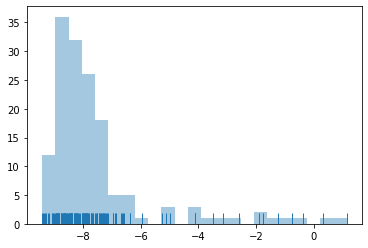

In [8]:
sns.distplot(start_scores.cpu(), kde=False, rug=True)

In [9]:
prefix = tokenizer.decode(input_ids[torch.argmax(start_scores)-8: torch.argmax(start_scores)])
answer = tokenizer.decode(input_ids[torch.argmax(start_scores): torch.argmax(end_scores)+1])
suffix = tokenizer.decode(input_ids[torch.argmax(end_scores)+1: torch.argmax(end_scores)+8])

'... ' + prefix + ' >>> ' + answer + ' <<< ' + suffix + ' ...'

"... of descartes'idealism. >>> kant <<< says that it is not possible to ..."

In [10]:
# prepare batch for inference

question_df['encoded'] = question_df.apply(lambda row: tokenizer.encode("[CLS] " + row['question'] + " [SEP] " + row['context'] + " [SEP]", add_special_tokens=False), axis=1)
question_df['token_type_ids'] = question_df.apply(lambda row: [0 if i<=row['encoded'].index(102) else 1 for i in range(len(row['encoded']))], axis=1)
question_df.iloc[:3]

,question,context,encoded,token_type_ids
0,Who is a notable exponent of pluralistic ideal...,Pluralistic idealism such as that of Gottfried...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
1,Who is a notable exponent of pluralistic ideal...,The 2nd edition (1787) contained a Refutation ...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,Who is a notable exponent of pluralistic ideal...,"In philosophy, idealism is the group of philos...","[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."


In [11]:
%%time 

with torch.no_grad():
    X = torch.nn.utils.rnn.pad_sequence([torch.tensor(row) for row in question_df['encoded']], batch_first=True).to(device)
    T = torch.nn.utils.rnn.pad_sequence([torch.tensor(row) for row in question_df['token_type_ids']], batch_first=True).to(device)
    start_scores, end_scores = model(X, token_type_ids=T)
    max_score, max_start = torch.max(start_scores, axis=1)
    soft_max = F.softmax(max_score, dim=0)

CPU times: user 42.2 s, sys: 1.08 s, total: 43.3 s
Wall time: 7.29 s


In [12]:
%%time 

preds = qa_pipe(question_df.to_dict(orient='records'))
answer_df = pd.DataFrame.from_records(preds)
answer_df['context'] = question_df['context']
answer_df = answer_df.sort_values(by='score', ascending=False)
answer_df.head()

CPU times: user 12.1 s, sys: 364 ms, total: 12.5 s
Wall time: 3.27 s


,score,start,end,answer,context
0,0.986910,37,54,Gottfried Leibniz,Pluralistic idealism such as that of Gottfried...
4,0.889905,0,4,Kant,Kant argued against all three forms of materia...
5,0.879589,200,216,Woodrow Wilson's,Idealism is a term with several related meanin...
1,0.699285,106,117,Descartes's,The 2nd edition (1787) contained a Refutation ...
7,0.696889,342,359,Platonic idealism,Any philosophy that assigns crucial importance...


In [12]:
answer_df = question_df[['context', 'encoded']].copy()
answer_df['answer_score'] = max_score.cpu().numpy()
answer_df['answer_start'] = max_start.cpu().numpy()
answer_df['answer_softmax'] = soft_max.cpu().numpy()
answer_df

,context,encoded,answer_score,answer_start,answer_softmax
0,Pluralistic idealism such as that of Gottfried...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",7.349265,22,0.925584
1,The 2nd edition (1787) contained a Refutation ...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",0.306006,0,0.000808
2,"In philosophy, idealism is the group of philos...","[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",-1.357682,0,0.000153
3,Absolute idealism is G. W. F. Hegel's account ...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",-0.208937,0,0.000483
4,Kant argued against all three forms of materia...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",0.533006,0,0.001014
5,Idealism is a term with several related meanin...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",3.274640,64,0.015734
6,Subjective idealists like George Berkeley are ...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",0.780697,0,0.001299
7,Any philosophy that assigns crucial importance...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",0.922421,0,0.001497
8,"Plato's theory of forms or ""ideas"" describes i...","[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",4.410364,54,0.048986
9,"Beginning with Immanuel Kant, German idealists...","[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",2.009783,16,0.004441


In [13]:
max_len = torch.zeros_like(max_start)
for i in range(max_start.shape[0]):
    max_len[i] = torch.argmax(end_scores[i, max_start[i]:]) + 1

answer_df['answer_length'] = max_len.cpu().numpy()

In [14]:
answer_df = answer_df[answer_df.answer_score > 1.0].sort_values(by='answer_score', ascending=False)
answer_df.head()

,context,encoded,answer_score,answer_start,answer_softmax,answer_length
0,Pluralistic idealism such as that of Gottfried...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",7.349265,22,0.925584,4
8,"Plato's theory of forms or ""ideas"" describes i...","[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",4.410364,54,0.048986,5
5,Idealism is a term with several related meanin...,"[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",3.274640,64,0.015734,2
9,"Beginning with Immanuel Kant, German idealists...","[101, 2040, 2003, 1037, 3862, 16258, 21576, 19...",2.009783,16,0.004441,4


In [15]:
def decode_answer(row):
    input_ids = row.encoded
    offset = row.answer_start
    length = np.clip(row.answer_length, 0, 20)
    return tokenizer.decode(input_ids[offset:][:length])

In [18]:
answer_df['answer'] = answer_df.apply(decode_answer, axis=1)
answer_df[['answer_softmax', 'answer_score', 'answer']].head()

,answer_softmax,answer_score,answer
0,0.925584,7.349265,gottfried leibniz
8,0.048986,4.410364,arne grøn
5,0.015734,3.274640,woodrow wilson
9,0.004441,2.009783,immanuel kant


In [19]:
answer_df[['answer_softmax', 'answer_score', 'answer', 'context']].iloc[:3].to_dict(orient='records')

[{'answer_softmax': 0.9255843758583069,
  'answer_score': 7.349264621734619,
  'answer': 'gottfried leibniz',
  'context': 'Pluralistic idealism such as that of Gottfried Leibniz takes the view that there are many individual minds that together underlie the existence of the observed world and make possible the existence of the physical universe. Unlike absolute idealism, pluralistic idealism does not assume the existence of a single ultimate mental reality or "Absolute". Leibniz\' form of idealism, known as Panpsychism, views "monads" as the true atoms of the universe and as entities having perception. The monads are "substantial forms of being",elemental, individual, subject to their own laws, non-interacting, each reflecting the entire universe. Monads are centers of force, which is substance while space, matter and motion are phenomenal and their form and existence is dependent on the simple and immaterial monads. There is a pre-established harmony established by God, the central mo